<a href="https://colab.research.google.com/github/Wolf0605/Transfer_learning/blob/main/cat_vs_dog_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import shutil
import tqdm

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
file_dir = '/content/drive/MyDrive/cat vs dog/dogs-vs-cats'

CONTENT_DIR = '/content/drive/MyDrive/content'
TRAIN_DIR = CONTENT_DIR + '/train'
VALID_DIR = CONTENT_DIR + '/valid'

TRAIN_DIR_DOG = TRAIN_DIR + '/dog'
TRAIN_DIR_CAT = TRAIN_DIR + '/cat'

VALID_DIR_DOG = VALID_DIR + '/dog'
VALID_DIR_CAT = VALID_DIR + '/cat'

In [6]:
CONTENT_DIR = '/content/drive/MyDrive/content'
TRAIN_DIR = CONTENT_DIR + '/train'
VALID_DIR = CONTENT_DIR + '/valid'

if not os.path.exists(CONTENT_DIR):
    # Extract dataset
  import zipfile
  with zipfile.ZipFile('/content/drive/MyDrive/cat vs dog/dogs-vs-cats/train.zip', 'r') as zipf:
    zipf.extractall(CONTENT_DIR)

In [ ]:
TRAIN_DIR_DOG = TRAIN_DIR + '/dog'
TRAIN_DIR_CAT = TRAIN_DIR + '/cat'

VALID_DIR_DOG = VALID_DIR + '/dog'
VALID_DIR_CAT = VALID_DIR + '/cat'

img_filenames = os.listdir(os.path.join(CONTENT_DIR, 'train'))
cat_files = [fn for fn in img_filenames if 'cat' in fn]
dog_files = [fn for fn in img_filenames if 'dog' in fn]
print(len(cat_files))
print(len(dog_files))

dataset_files = train_test_split(dog_files, cat_files, test_size=0.1, shuffle=True, random_state=42)

In [ ]:
# makde dirs
# Error 
# eactuallu : [TRAIN_DOG, VALID_DOG, TRAIN_CAT, VALID_CAT]
names = [TRAIN_DIR_DOG, TRAIN_DIR_CAT, VALID_DIR_DOG, VALID_DIR_CAT]
for name, dataset_file in zip(names, dataset_files)
  os.makedirs(name, exist_ok=True)
  for file in tqdm.tqdm(dataset_file):
    shutil.move(os.path.join(TRAIN_DIR, file), name)
  print(f'elements in {name} : {len(os.listdir(name))}')

In [ ]:
names = [TRAIN_DIR_DOG, VALID_DIR_DOG, TRAIN_DIR_CAT, VALID_DIR_CAT]

for name in names:
  print(len(os.listdir(name)))

11250
1250
11250
1250


## Preprocessing

In [7]:
BATCH_SIZE = 32
IMAGE_SHAPE = 128

In [8]:
# make data generators
train_generator = ImageDataGenerator(rescale=1./255)
valid_generator = ImageDataGenerator(rescale=1./255)

train_data = train_generator.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(IMAGE_SHAPE, IMAGE_SHAPE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)
valid_data = valid_generator.flow_from_directory(
    directory=VALID_DIR,
    target_size=(IMAGE_SHAPE, IMAGE_SHAPE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


## Xception

In [9]:
# load xception model
xception_model = tf.keras.applications.xception.Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(IMAGE_SHAPE, IMAGE_SHAPE, 3),
    pooling='avg'
)

83697664/83683744 [==============================] - 1s 0us/step


In [10]:
# bottleneck features for train dataset
train_bottleneck = xception_model.predict_generator(
    train_data, train_data.n // BATCH_SIZE, verbose=1
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


703/703 [==============================] - 3905s 6s/step


In [ ]:
valid_bottleneck = xception_model.predict_generator(
    valid_data, valid_data.n // BATCH_SIZE, verbose=1
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


56/78 [====================>.........] - ETA: 2:03

In [15]:
# create simple model for classification
model = tf.keras.models.Sequential([
    Dense(units=256, activation='relu', input_shape=xception_model.output_shape[1:]),
    Dropout(0.5),
    Dense(units=128, activation='relu'),
    Dropout(0.5),
    Dense(units=2, activation='softmax')
])

In [16]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [17]:
# get predicted features and classify it
EPOCHS = 10
history = model.fit(
    x=train_bottleneck,
    y=train_data.labels[:len(train_bottleneck)],
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(valid_bottleneck, valid_data.labels[:len(valid_bottleneck)])
)

Epoch 1/10
703/703 [==============================] - 6s 8ms/step - loss: 0.1798 - accuracy: 0.9262 - val_loss: 0.1336 - val_accuracy: 0.9451
Epoch 2/10
703/703 [==============================] - 5s 7ms/step - loss: 0.1379 - accuracy: 0.9440 - val_loss: 0.1298 - val_accuracy: 0.9495
Epoch 3/10
703/703 [==============================] - 5s 7ms/step - loss: 0.1243 - accuracy: 0.9515 - val_loss: 0.1314 - val_accuracy: 0.9507
Epoch 4/10
703/703 [==============================] - 5s 7ms/step - loss: 0.1174 - accuracy: 0.9538 - val_loss: 0.1415 - val_accuracy: 0.9407
Epoch 5/10
703/703 [==============================] - 5s 7ms/step - loss: 0.1133 - accuracy: 0.9558 - val_loss: 0.1303 - val_accuracy: 0.9499
Epoch 6/10
703/703 [==============================] - 5s 7ms/step - loss: 0.1036 - accuracy: 0.9579 - val_loss: 0.1316 - val_accuracy: 0.9499
Epoch 7/10
703/703 [==============================] - 5s 7ms/step - loss: 0.1010 - accuracy: 0.9592 - val_loss: 0.1287 - val_accuracy: 0.9455
Epoch 

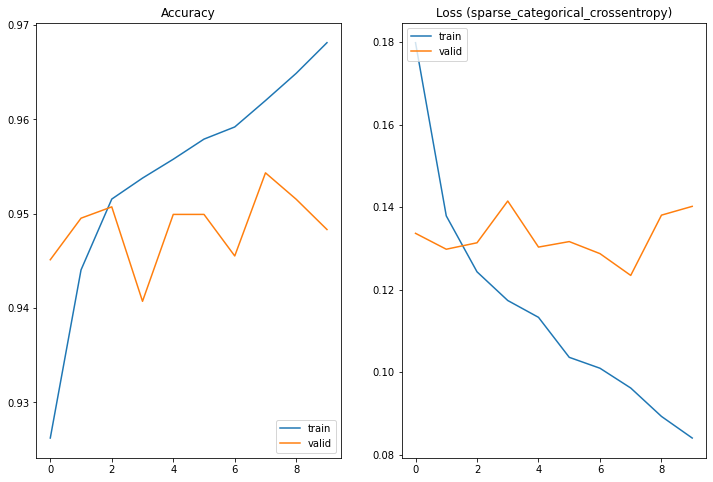

In [18]:
def show_graphs(history):
    plt.figure(figsize=(12, 8))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='valid')
    plt.legend(loc='lower right')
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='valid')
    plt.legend(loc='upper left')
    plt.title('Loss (sparse_categorical_crossentropy)')

    plt.show()
    
show_graphs(history)

## MobileNet

In [19]:
mobilenet_model = tf.keras.applications.mobilenet.MobileNet(
    include_top=False,
    weights='imagenet',
    input_shape=(IMAGE_SHAPE, IMAGE_SHAPE, 3),
    pooling='avg'
)
mobilenet_model.trainable = False # freeze convolutional layers

17235968/17225924 [==============================] - 0s 0us/step


In [20]:
# new fully connected part of the network
dense_model = tf.keras.models.Sequential([
    Dense(units=1000, activation='relu'),
    Dropout(0.5),
    Dense(units=128, activation='relu'),
    Dropout(0.5),
    Dense(units=2, activation='softmax')
])

In [21]:
# build a new model
model2 = tf.keras.models.Sequential([
    mobilenet_model,
    dense_model
])

In [22]:
model2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [23]:
EPOCHS = 10
train_data.reset()
valid_data.reset()
history = model2.fit_generator(
    train_data,
    steps_per_epoch=train_data.n // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=valid_data,
    validation_steps=valid_data.n // BATCH_SIZE
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/10
703/703 [==============================] - 369s 523ms/step - loss: 0.1660 - accuracy: 0.9432 - val_loss: 0.0960 - val_accuracy: 0.9724
Epoch 2/10
703/703 [==============================] - 362s 514ms/step - loss: 0.0886 - accuracy: 0.9685 - val_loss: 0.0669 - val_accuracy: 0.9708
Epoch 3/10
703/703 [==============================] - 359s 511ms/step - loss: 0.0700 - accuracy: 0.9738 - val_loss: 0.0616 - val_accuracy: 0.9740
Epoch 4/10
703/703 [==============================] - 357s 508ms/step - loss: 0.0645 - accuracy: 0.9757 - val_loss: 0.0726 - val_accuracy: 0.9768
Epoch 5/10
703/703 [==============================] - 358s 509ms/step - loss: 0.0613 - accuracy: 0.9777 - val_loss: 0.0610 - val_accuracy: 0.9784
Epoch 6/10
703/703 [==============================] - 359s 510ms/step - loss: 0.0575 - accuracy: 0.9789 - val_loss: 0.0708 - val_accuracy: 0.9764
Epoch 7/10
703/703 [==============================] - 357s 507ms/step - loss: 0.0520 - accuracy: 0.9804 - val_loss: 0.1649 -

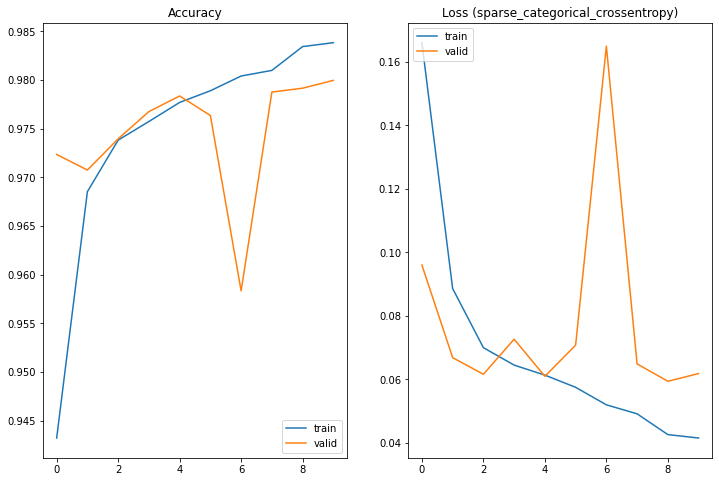

In [24]:
show_graphs(history)

## MobileNet with native output layer

In [25]:
IMAGE_SHAPE = 224
example_data = train_generator.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(IMAGE_SHAPE, IMAGE_SHAPE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)
example_x, example_y = example_data.next()
example_classes = list(example_data.class_indices.keys())
example_y_classes = [example_classes[int(i)] for i in example_y]

Found 22500 images belonging to 2 classes.


In [26]:
mobilenet_native = tf.keras.applications.mobilenet.MobileNet(
    include_top=True,
    weights='imagenet',
    input_shape=(IMAGE_SHAPE, IMAGE_SHAPE, 3),
    pooling='avg'
)
mobilenet_native.compile()
example_pred = mobilenet_native.predict(
    example_x
)

17235968/17225924 [==============================] - 0s 0us/step


In [27]:
labels_path = tf.keras.utils.get_file(
    'ImageNetLabels.txt',
    'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt'
)
imagenet_labels = np.array(open(labels_path).read().splitlines())
result = imagenet_labels[np.argmax(example_pred, axis=1)]

24576/10484 [======================================================================] - 0s 0us/step


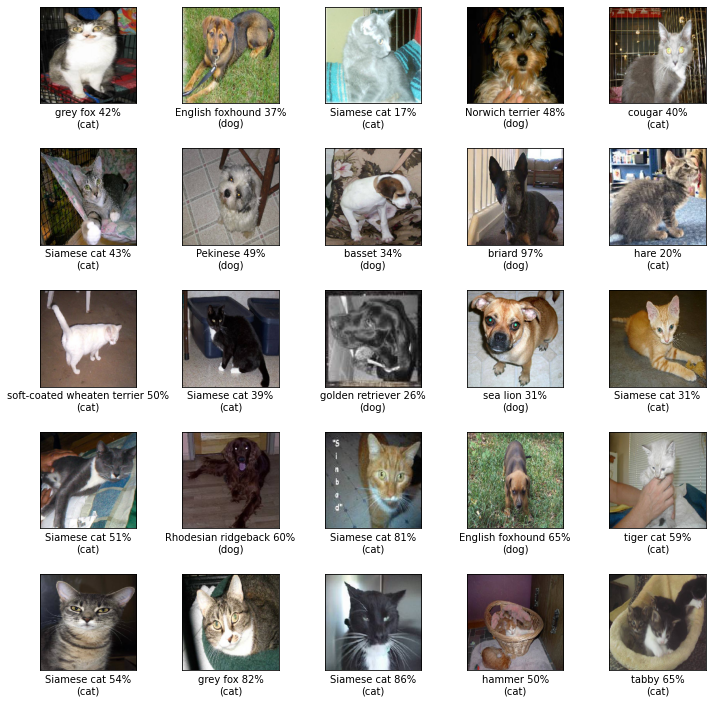

In [28]:
NUM_ROWS = 5
NUM_COLS = 5
NUM_IMAGES = NUM_COLS * NUM_ROWS
plt.figure(figsize=(2*NUM_COLS, 2*NUM_ROWS))
for i in range(NUM_IMAGES):
    plt.subplot(NUM_ROWS, NUM_COLS, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(example_x[i], cmap=plt.cm.binary)
    plt.xlabel('{} {:.0%}\n({})'.format(result[i], np.max(example_pred[i]), example_y_classes[i]))
plt.tight_layout()
plt.show()